<a href="https://colab.research.google.com/github/anmol-singh7/GenAI-Exploration/blob/main/Major_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import pandas as pd
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

In [2]:
START = "2015-01-01"
TODAY = "2024-12-31"

# Define a function to load the dataset

def load_data(ticker):
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    return data

In [3]:
df = load_data('AAPL')
df.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
0,2015-01-02,24.288580,24.757334,23.848706,24.746226,212818400
1,2015-01-05,23.604330,24.137511,23.417718,24.057533,257142000
2,2015-01-06,23.606554,23.866479,23.244435,23.668758,263188400
3,2015-01-07,23.937572,24.037543,23.704305,23.815385,160423600
4,2015-01-08,24.857307,24.915069,24.148621,24.266367,237458000


In [4]:
# Load the dataset
df = df.drop(index=0)  # Drop repeated header
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df[['Close', 'High', 'Low', 'Open', 'Volume']] = df[['Close', 'High', 'Low', 'Open', 'Volume']].apply(pd.to_numeric)
df = df.sort_values("Date").reset_index(drop=True)




In [5]:
# Normalize features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close', 'High', 'Low', 'Open', 'Volume']])


In [6]:
# Create sequences
SEQUENCE_LENGTH = 60
X, y = [], []
for i in range(SEQUENCE_LENGTH, len(scaled_data)):
    X.append(scaled_data[i-SEQUENCE_LENGTH:i])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

# Train/test split



In [7]:
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]



In [8]:
# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


In [10]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0128 - val_loss: 9.4414e-04
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0014 - val_loss: 7.6027e-04
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010 - val_loss: 6.8475e-04
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.6952e-04 - val_loss: 7.0586e-04
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.9075e-04 - val_loss: 7.5747e-04
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010 - val_loss: 7.1454e-04
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.2700e-04 - val_loss: 7.7990e-04
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.7895e-04 - val_loss: 6.6685e-04
Epoch 12/20
56/56 ━━━

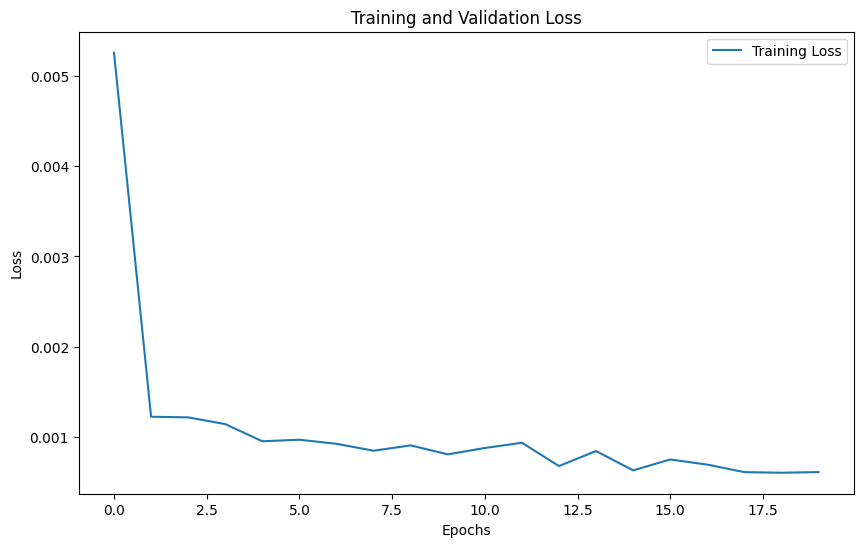

In [11]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
y_pred = model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [13]:
# Only the 'Close' column was used as the target
close_index = list(df.columns).index("Close") - 1  # Adjust for dropped index column
y_pred_rescaled = scaler.inverse_transform(
    np.concatenate([y_pred, np.zeros((len(y_pred), 4))], axis=1)
)[:, 0]
y_test_rescaled = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1, 1), np.zeros((len(y_test), 4))], axis=1)
)[:, 0]


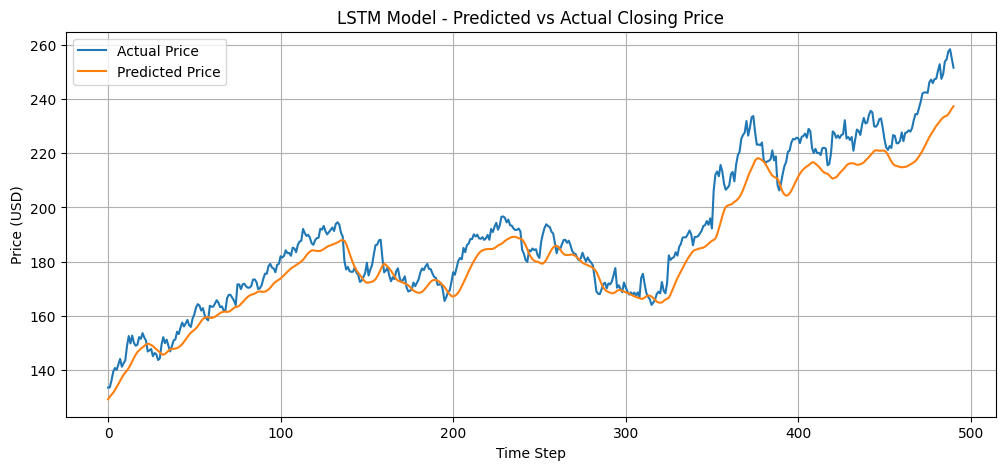

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test_rescaled, label='Actual Price')
plt.plot(y_pred_rescaled, label='Predicted Price')
plt.title('LSTM Model - Predicted vs Actual Closing Price')
plt.xlabel('Time Step')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")


MAE: 7.0597, RMSE: 8.8065


In [16]:
from sklearn.metrics import r2_score

# Actual values
actual = y_test

# Predicted values
predicted = y_pred

# Calculate the R2 score
r2 = r2_score(actual, predicted)

print("R2 score:", r2)

R2 score: 0.8934451131611016


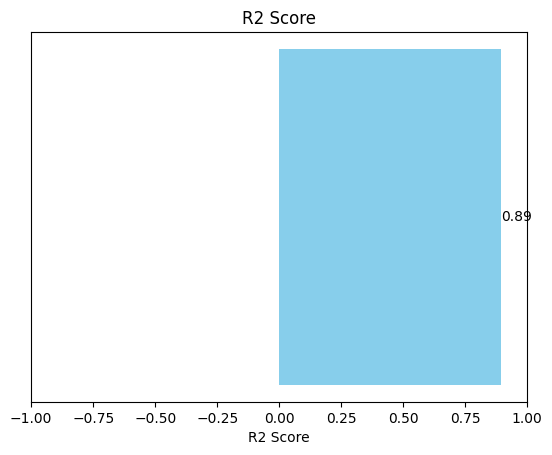

In [17]:
# Plotting the R2 score
fig, ax = plt.subplots()
ax.barh(0, r2, color='skyblue')
ax.set_xlim([-1, 1])
ax.set_yticks([])
ax.set_xlabel('R2 Score')
ax.set_title('R2 Score')

# Adding the R2 score value on the bar
ax.text(r2, 0, f'{r2:.2f}', va='center', color='black')

plt.show()

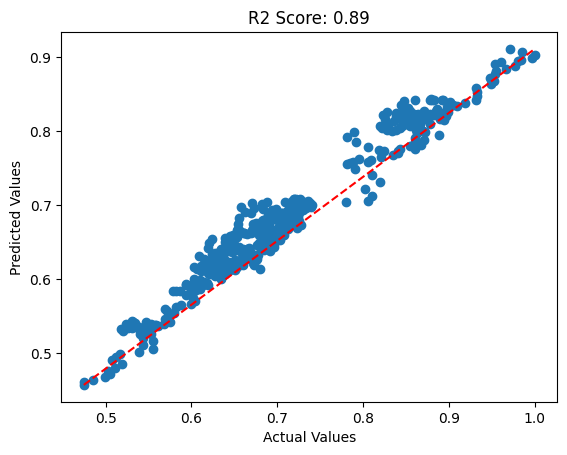

In [18]:
plt.scatter(actual, predicted)
plt.plot([min(actual), max(actual)], [min(predicted), max(predicted)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'R2 Score: {r2:.2f}')
plt.show()

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# CNN Model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

cnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train CNN


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
cnn_history = cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0103 - val_loss: 0.0023
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - val_loss: 0.0037
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 0.0054
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 0.0078
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 12/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_l

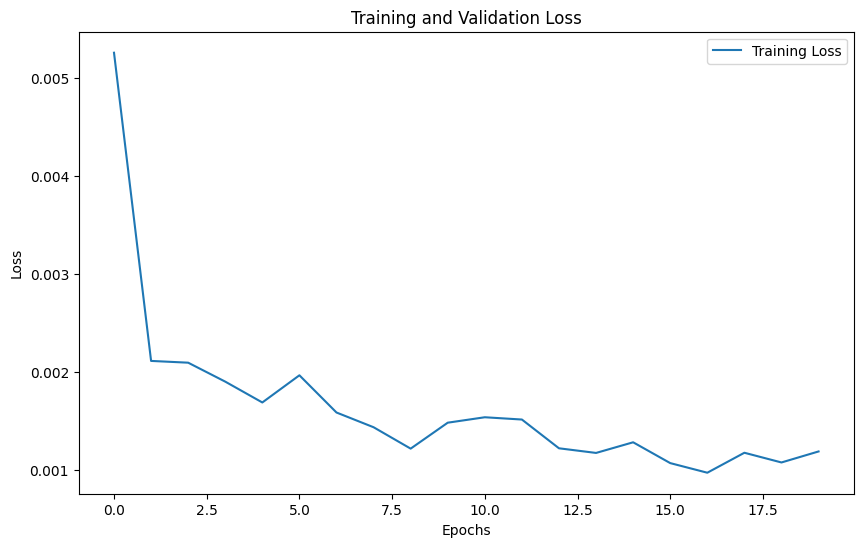

In [21]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(cnn_history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
y_pred = cnn_model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [23]:
# Only the 'Close' column was used as the target
close_index = list(df.columns).index("Close") - 1  # Adjust for dropped index column
y_pred_rescaled = scaler.inverse_transform(
    np.concatenate([y_pred, np.zeros((len(y_pred), 4))], axis=1)
)[:, 0]
y_test_rescaled = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1, 1), np.zeros((len(y_test), 4))], axis=1)
)[:, 0]


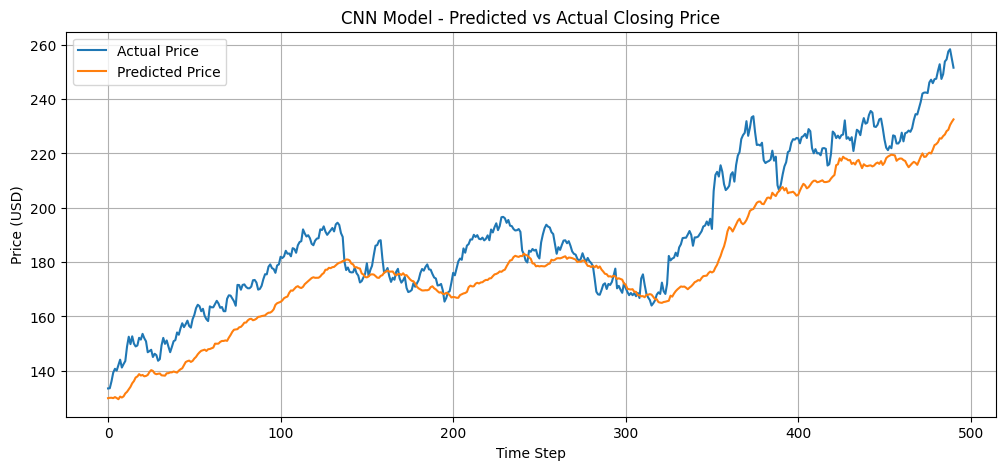

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test_rescaled, label='Actual Price')
plt.plot(y_pred_rescaled, label='Predicted Price')
plt.title('CNN Model - Predicted vs Actual Closing Price')
plt.xlabel('Time Step')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")


MAE: 11.8164, RMSE: 13.9550


In [26]:
from sklearn.metrics import r2_score

# Actual values
actual = y_test

# Predicted values
predicted = y_pred

# Calculate the R2 score
r2 = r2_score(actual, predicted)

print("R2 score:", r2)

R2 score: 0.7324364745115624


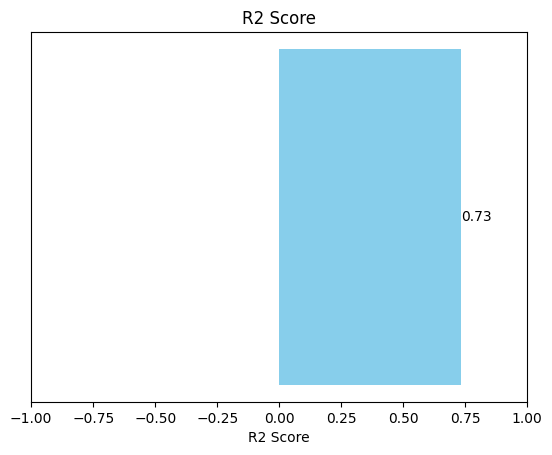

In [27]:
# Plotting the R2 score
fig, ax = plt.subplots()
ax.barh(0, r2, color='skyblue')
ax.set_xlim([-1, 1])
ax.set_yticks([])
ax.set_xlabel('R2 Score')
ax.set_title('R2 Score')

# Adding the R2 score value on the bar
ax.text(r2, 0, f'{r2:.2f}', va='center', color='black')

plt.show()

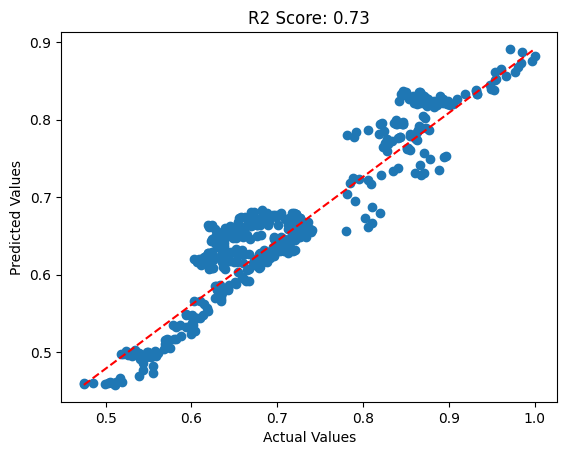

In [28]:
plt.scatter(actual, predicted)
plt.plot([min(actual), max(actual)], [min(predicted), max(predicted)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'R2 Score: {r2:.2f}')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step
1/1 ━━━━━━━━━━━━

<Figure size 640x480 with 0 Axes>

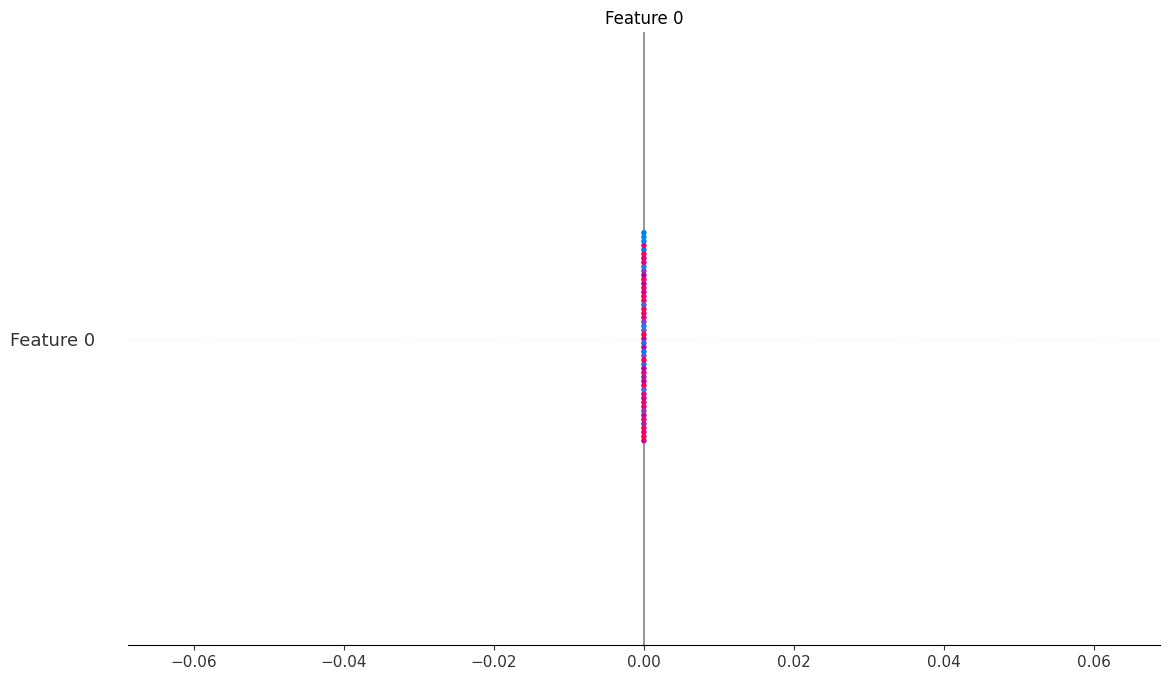

In [29]:
import shap
import numpy as np

# Flatten your input sequences for SHAP (needed for KernelExplainer)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test[:50].reshape(50, -1)

# Define a prediction function that reshapes input for the model
def model_predict(x_flat):
    x_reshaped = x_flat.reshape(x_flat.shape[0], 60, 5)
    return model.predict(x_reshaped)

# Initialize SHAP KernelExplainer
explainer = shap.KernelExplainer(model_predict, X_train_flat[:100])

# Compute SHAP values
shap_values = explainer.shap_values(X_test_flat)

# Plot summary
shap.summary_plot(shap_values, X_test_flat)


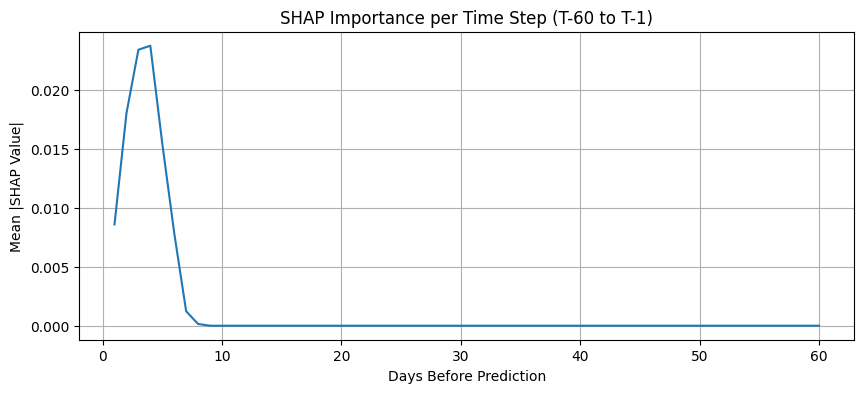

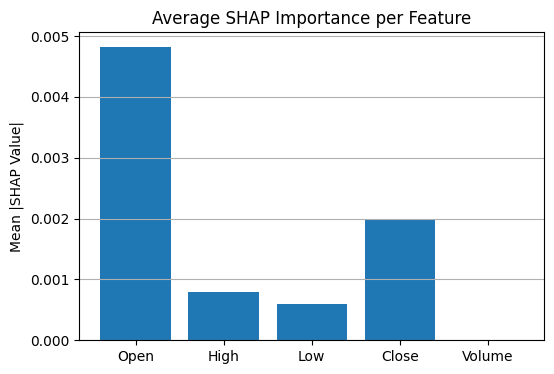

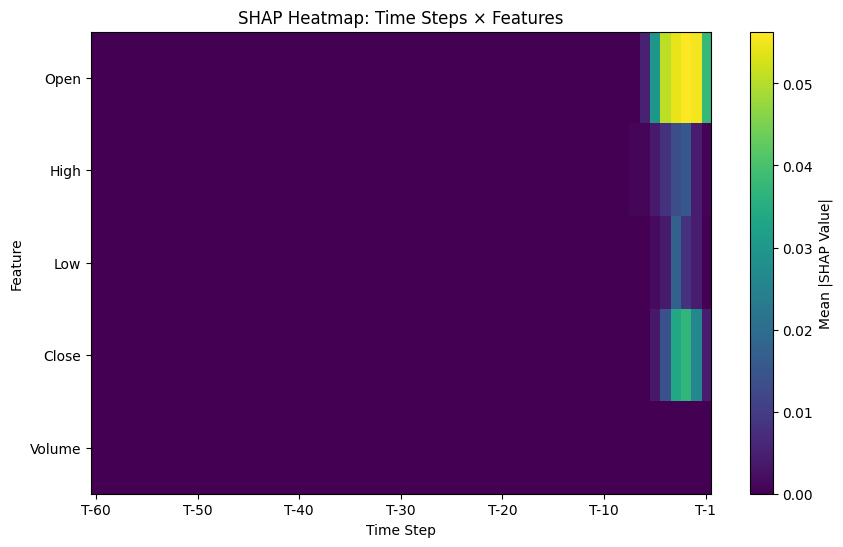

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Convert flat SHAP values into (samples, 60, 5)
shap_array = np.array(shap_values)        # shape: (n_samples, 300)
shap_reshaped = shap_array.reshape((shap_array.shape[0], 60, 5))  # shape: (samples, time, features)

# 2. Compute average absolute SHAP values
shap_time_importance = np.abs(shap_reshaped).mean(axis=0).mean(axis=1)      # shape: (60,)
shap_feature_importance = np.abs(shap_reshaped).mean(axis=0).mean(axis=0)   # shape: (5,)

# 3. Plot SHAP importance per time step (like attention heatmap)
plt.figure(figsize=(10, 4))
plt.plot(range(60, 0, -1), shap_time_importance)
plt.title("SHAP Importance per Time Step (T-60 to T-1)")
plt.xlabel("Days Before Prediction")
plt.ylabel("Mean |SHAP Value|")
plt.grid(True)
plt.show()

# 4. Plot feature-wise importance
feature_names = ["Open", "High", "Low", "Close", "Volume"]
plt.figure(figsize=(6, 4))
plt.bar(feature_names, shap_feature_importance)
plt.title("Average SHAP Importance per Feature")
plt.ylabel("Mean |SHAP Value|")
plt.grid(axis='y')
plt.show()

# 5. Plot full SHAP heatmap across [time × features]
avg_shap_map = np.abs(shap_reshaped).mean(axis=0)  # shape: (60, 5)
plt.figure(figsize=(10, 6))
plt.imshow(avg_shap_map.T, cmap="viridis", aspect="auto", interpolation="nearest")
plt.colorbar(label='Mean |SHAP Value|')
plt.yticks(np.arange(len(feature_names)), feature_names)
plt.xticks(np.linspace(0, 59, 7), [f"T-{int(t)}" for t in np.linspace(60, 1, 7)])
plt.title("SHAP Heatmap: Time Steps × Features")
plt.xlabel("Time Step")
plt.ylabel("Feature")
plt.show()


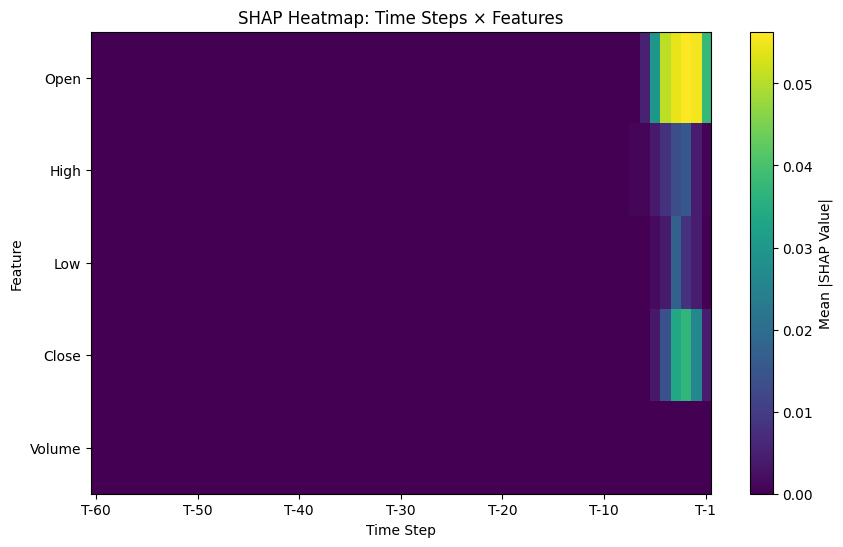

In [32]:
# Assumes shap_reshaped is (samples, 60, 5)
avg_shap_map = np.abs(shap_reshaped).mean(axis=0)  # shape: (60, 5)

plt.figure(figsize=(10, 6))
plt.imshow(avg_shap_map.T, cmap="viridis", aspect="auto", interpolation="nearest")
plt.colorbar(label='Mean |SHAP Value|')
plt.yticks(np.arange(len(feature_names)), feature_names)
plt.xticks(np.linspace(0, 59, 7), [f"T-{int(t)}" for t in np.linspace(60, 1, 7)])
plt.title("SHAP Heatmap: Time Steps × Features")
plt.xlabel("Time Step")
plt.ylabel("Feature")
plt.show()


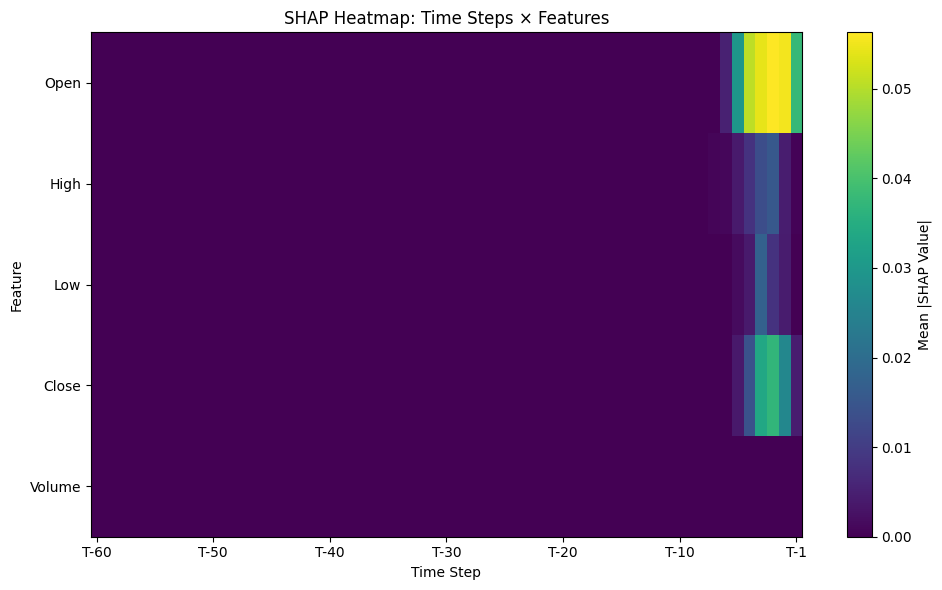

In [34]:
# Flattened SHAP output shape = (samples, 60*5)
shap_array = np.array(shap_values)
shap_reshaped = shap_array.reshape((shap_array.shape[0], 60, 5))
avg_shap_map = np.abs(shap_reshaped).mean(axis=0)  # shape: (60, 5)

import matplotlib.pyplot as plt

feature_names = ["Open", "High", "Low", "Close", "Volume"]

plt.figure(figsize=(10, 6))
plt.imshow(avg_shap_map.T, cmap="viridis", aspect="auto", interpolation="nearest")
plt.colorbar(label='Mean |SHAP Value|')
plt.yticks(np.arange(len(feature_names)), feature_names)
plt.xticks(np.linspace(0, 59, 7), [f"T-{int(t)}" for t in np.linspace(60, 1, 7)])
plt.title("SHAP Heatmap: Time Steps × Features")
plt.xlabel("Time Step")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



In [35]:
pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=2094cc894c928e9a34e45d35c80f2e1586bbe5309fb7ccefe3a58389020539cd
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [36]:
import lime
import lime.lime_tabular
import numpy as np

# Flatten input for LIME
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Wrap the CNN model prediction to accept flattened input
def cnn_predict_flat(x_flat):
    x_reshaped = x_flat.reshape(x_flat.shape[0], 60, 5)
    return cnn_model.predict(x_reshaped)

# Create LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_flat,
    mode='regression',
    feature_names=[f"T-{59 - i//5} {['Open','High','Low','Close','Volume'][i % 5]}" for i in range(60*5)],
    discretize_continuous=False
)

# Pick a test sample to explain
i = 0
sample_input = X_test_flat[i]

# Explain prediction
exp = explainer.explain_instance(sample_input, cnn_predict_flat, num_features=10)

# Visualize explanation
exp.show_in_notebook(show_table=True)

# (Optional) Save HTML if you're in Jupyter
exp.save_to_file('lime_explanation_sample.html')


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [37]:
pip install tensorflow

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0143 - val_loss: 0.0040
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - val_loss: 0.0095
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.3349e-04 - val_loss: 0.0037
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0010 - val_loss: 0.0028
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.3621e-04 - val_loss: 0.0036
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.8103e-04 - val_loss: 0.0041
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.4460e-04 - val_loss: 0.0029
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.7473e-04 - val_loss: 0.0028
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.7542e-04 - val_loss: 0.0025
Epoch 12/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/ste

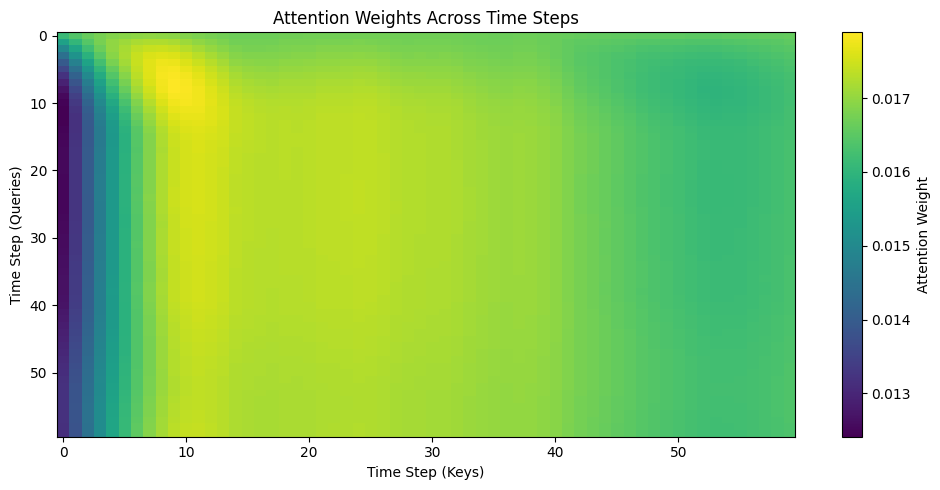

In [39]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Layer
import matplotlib.pyplot as plt

# 1. Custom Attention Layer
class AttentionLayer(Layer):
    def call(self, inputs):
        query, value = inputs
        score = tf.matmul(query, value, transpose_b=True)
        weights = tf.nn.softmax(score, axis=-1)
        context = tf.matmul(weights, value)
        return context, weights

# 2. Build Attention-LSTM model
from tensorflow.keras.layers import Lambda

# Build Attention-LSTM model
def build_attention_lstm(input_shape):
    inputs = Input(shape=input_shape)
    lstm_out, state_h, state_c = LSTM(64, return_sequences=True, return_state=True)(inputs)
    context, attention_weights = AttentionLayer()([lstm_out, lstm_out])
    context_vector = Lambda(lambda x: tf.reduce_mean(x, axis=1))(context)
    x = Dropout(0.2)(context_vector)
    x = Dense(32, activation='relu')(x)
    output = Dense(1)(x)

    model = Model(inputs, output)
    attention_model = Model(inputs, attention_weights)
    return model, attention_model


# 3. Prepare your data (replace with your actual X_train and y_train)
# Example:
# X_train = your full (samples, 60, 5) training data
# y_train = target closing prices
input_shape = (60, 5)
model, attn_model = build_attention_lstm(input_shape)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# 4. Get attention weights for one sample
attention_weights = attn_model.predict(X_test[:1])  # shape: (1, 60, 60)

# 5. Plot attention heatmap
plt.figure(figsize=(10, 5))
plt.imshow(attention_weights[0], cmap="viridis", aspect="auto")
plt.title("Attention Weights Across Time Steps")
plt.xlabel("Time Step (Keys)")
plt.ylabel("Time Step (Queries)")
plt.colorbar(label="Attention Weight")
plt.tight_layout()
plt.show()
